In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import seaborn as sns

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 15
END_YEAR = 2015

### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

In [2]:
start_time = timeit.default_timer()
print(start_time)

1.184239664844385e-06


### Read Gender details

In [3]:
# read gender details - the column names are name, gender - change it to author, gender
#gender = pd.read_csv('./data/name_gender_1970_2016_noAsians.csv')
gender = pd.read_csv('./data-new/name_gender_2017_asiansAsNone.txt')

gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender.groupby('gender').size())
#TODO: also show proportion! What is the percentage of men and women?

print(gender['author'].nunique())

          author gender
0   gareth beale      m
1    graeme earl      m
2  altaf hossain      m
3   faisal zaman      m
4      m. nasser   none
['m' 'none' 'f']
gender
f       1046534
m       4621274
none    3803920
dtype: int64
1704919


### Read authors with start and end year details

In [4]:

#authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorStartEndCareerData = pd.read_csv('./data-new/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

print(authorStartEndCareerData.head())

#print("authorStartEndCareerData  %s", authorStartEndCareerData.shape[0])
print("author unique names  - ", authorStartEndCareerData['author'].nunique())
#print(authorStartEndCareerData[authorStartEndCareerData['author']=='a min tjoa'])

authorStartEndCareerData before filtering -  112791
authorStartEndCareerData after filtering -  112791
               author  start_year  end_year  total_num_pub  career_length
0          a min tjoa        1979      2017            191             38
1          a-xing zhu        1998      2017             22             19
2  a. a. (louis) beex        1980      2016             31             36
3    a. a. abouelsoud        1996      2016             10             20
4          a. a. ball        1988      2006              5             18
author unique names  -  112791


### Merge credible authors and their gender information

In [5]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
print(authorStartEndCareerData.head())

print("authorStartEndCareerData with duplicates: %s", authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: %s", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData['author'].nunique())

#axes = authorStartEndCareerData.boxplot(column='pub_count', by='gender', return_type='axes')
#for ax in axes.values():
#    ax.set_ylim(0, 200)
#plt.show()

       author  start_year  end_year  total_num_pub  career_length gender
0  a min tjoa        1979      2017            191             38   none
1  a min tjoa        1979      2017            191             38   none
2  a min tjoa        1979      2017            191             38   none
3  a min tjoa        1979      2017            191             38   none
4  a min tjoa        1979      2017            191             38   none
authorStartEndCareerData with duplicates: %s 3884297
authorStartEndCareerData no duplicates: %s 112791


### Read Citation data

In [6]:
#authorCitationsData = pd.read_csv('./data/authors_cite_2016_asiansAsNone.txt')
#old data 
#authorCitationsData before filtering -  1904817
#authorCitationsData after filtering -  1904456

authorCitationsData = pd.read_csv('./data-new/authors_cite_2017_asiansAsNone.txt')


print('authorCitationsData before filtering - ',authorCitationsData.shape[0])
authorCitationsData = authorCitationsData[authorCitationsData["year"] >= 1970]
print('authorCitationsData after filtering - ',authorCitationsData.shape[0])

#id1 represents the author who cited
#id2 is the author who has been cited by id1 in year Y
authorCitationsData.rename(columns={'id2':'author'}, inplace=True)
print(authorCitationsData.head())

#Group by both year and author - multi index and hierarchial indexing
authorCitationsData = authorCitationsData.groupby(['year','author']).count().reset_index()
authorCitationsData.rename(columns={'id1':'num_cit'}, inplace=True)
print(authorCitationsData.head())

print(authorCitationsData[authorCitationsData.author == "stefano rizzi"])

##remove wrong data
#authorCitationsData = authorCitationsData[authorCitationsData["year"] > 1900]
#print(authorCitationsData[authorCitationsData.author=="a min tjoa"])

authorCitationsData before filtering -  6437633
authorCitationsData after filtering -  6436991
                    id1          author  year
0  rodrygo l. t. santos  milad shokouhi  2009
1       craig macdonald  milad shokouhi  2009
2              jie peng  milad shokouhi  2009
3     richard mccreadie  milad shokouhi  2009
4            iadh ounis  milad shokouhi  2009
   year                 author  num_cit
0  1970        albert r. meyer        1
1  1970      alexander s. lett        1
2  1970          alfred v. aho        2
3  1970  alston s. householder        1
4  1970            amir pnueli        1
        year         author  num_cit
121699  2001  stefano rizzi        3
142400  2002  stefano rizzi        4
198235  2004  stefano rizzi        1
279440  2006  stefano rizzi        5
330982  2007  stefano rizzi        5
389572  2008  stefano rizzi        8
457196  2009  stefano rizzi       22
527965  2010  stefano rizzi       15
606431  2011  stefano rizzi        4
687474  2012  stefa

### Merge Citations with credible authors and their gender information

In [7]:
authorCitationsData = pd.merge(authorCitationsData, authorStartEndCareerData,  
                                          how="left", left_on="author", right_on="author")

print("authorCitationsData before filtering: %s", authorCitationsData.shape[0])
authorCitationsData = authorCitationsData.dropna(how='any')
print("authorCitationsData after filtering: %s", authorCitationsData.shape[0])



authorCitationsData before filtering: %s 1049096
authorCitationsData after filtering: %s 473457


82386
     year                 author  num_cit  start_year  end_year  \
17   1970         david r. olsen        2      1970.0    2005.0   
21   1970    edward l. robertson        2      1970.0    2011.0   
33   1970  godfried t. toussaint        1      1970.0    2015.0   
81   1970    robert w. donaldson        1      1970.0    1997.0   
104  1971        arvind m. patel        2      1970.0    1986.0   

     total_num_pub  career_length gender  
17             6.0           35.0   none  
21            48.0           41.0   none  
33           169.0           45.0      f  
81            15.0           27.0   none  
104           14.0           16.0      m  


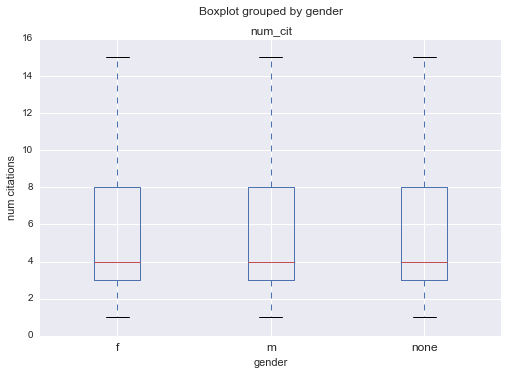

In [8]:
#print(authorCitationsData.head(n=2))
print(authorCitationsData['author'].nunique())
#print(authorCitationsData.shape[0])

print(authorCitationsData.head())
#print(authorCitationsData[authorCitationsData.author=="stefano rizzi"])


ax = authorCitationsData.boxplot(column='num_cit', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

### There are some differences between publication and citation data which is collected by DBLP and Aminer respectively
#### Data found for authors whose work were cited in the years which are lesser than their starting year of publishing. For our analysis these data are removed. Whereas author's work will be cited even after he/she ends their career

In [9]:
print('authorCitationsData before filtering', authorCitationsData.shape[0])
temp =  authorCitationsData[authorCitationsData['year'] < authorCitationsData['start_year']]
print(temp.shape[0],' rows were present')

authorCitationsData = authorCitationsData[authorCitationsData['year'] >= authorCitationsData['start_year']]
authorCitationsData = authorCitationsData.reset_index(drop = True)

print('authorCitationsData after filtering', authorCitationsData.shape[0])
print(authorCitationsData.head(10))

authorCitationsData before filtering 473457
117  rows were present
authorCitationsData after filtering 473340
   year                 author  num_cit  start_year  end_year  total_num_pub  \
0  1970         david r. olsen        2      1970.0    2005.0            6.0   
1  1970    edward l. robertson        2      1970.0    2011.0           48.0   
2  1970  godfried t. toussaint        1      1970.0    2015.0          169.0   
3  1970    robert w. donaldson        1      1970.0    1997.0           15.0   
4  1971        arvind m. patel        2      1970.0    1986.0           14.0   
5  1971           ben wegbreit        1      1970.0    2011.0           30.0   
6  1971      bruce g. buchanan        3      1971.0    2013.0           68.0   
7  1971             c. j. date        1      1971.0    2012.0            9.0   
8  1971    edward l. robertson        1      1970.0    2011.0           48.0   
9  1971       joshua lederberg        3      1971.0    1993.0            5.0   

   career

### Test Data

In [10]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

        year            author  num_cit  start_year  end_year  total_num_pub  \
37115   1997  donatella sciuto        2      1987.0    2016.0          349.0   
44411   1998  donatella sciuto        9      1987.0    2016.0          349.0   
61992   2000  donatella sciuto        4      1987.0    2016.0          349.0   
73049   2001  donatella sciuto       15      1987.0    2016.0          349.0   
85593   2002  donatella sciuto       25      1987.0    2016.0          349.0   
100127  2003  donatella sciuto       13      1987.0    2016.0          349.0   
117149  2004  donatella sciuto        3      1987.0    2016.0          349.0   
136979  2005  donatella sciuto       15      1987.0    2016.0          349.0   
159416  2006  donatella sciuto       38      1987.0    2016.0          349.0   
184057  2007  donatella sciuto        8      1987.0    2016.0          349.0   

        career_length gender  
37115            29.0      f  
44411            29.0      f  
61992            29.0     

# Cohort Analysis on all authors for 15 years

#### Select Cohorts based on Start Years

In [11]:
years = groupByYearData['year'].unique()
years = sorted(years)



cohort_start_years = [y for y in years if y < (END_YEAR - CAREER_LENGTH)]
print(cohort_start_years)
#cohort_start_years = [1974, 1984, 1994]

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]


### Cohort Analysis (Num Cit)

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\l

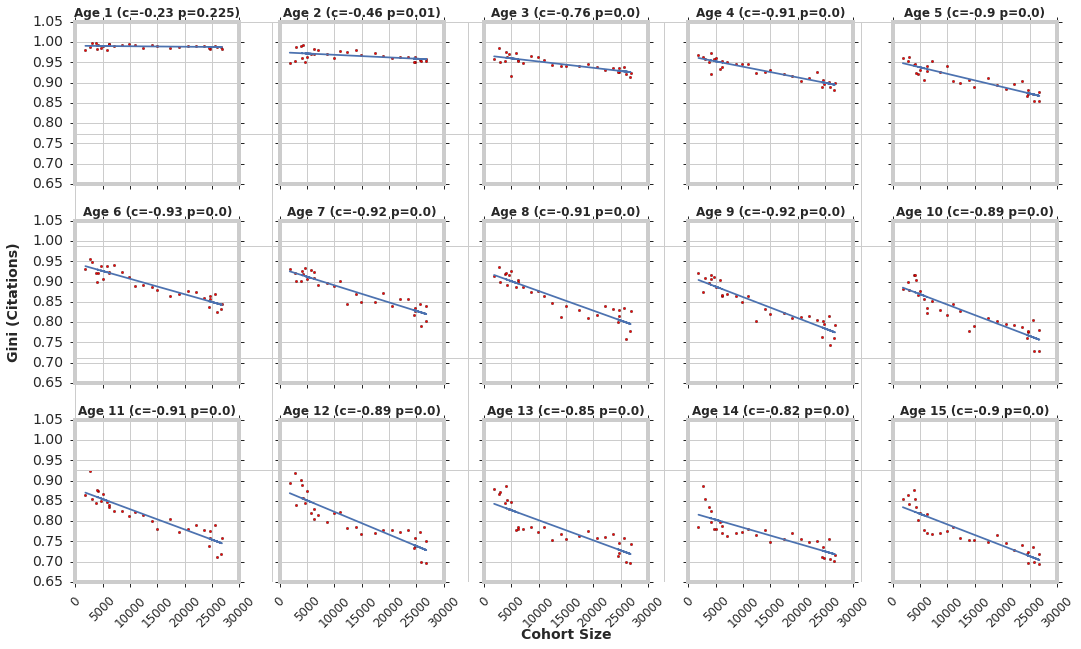

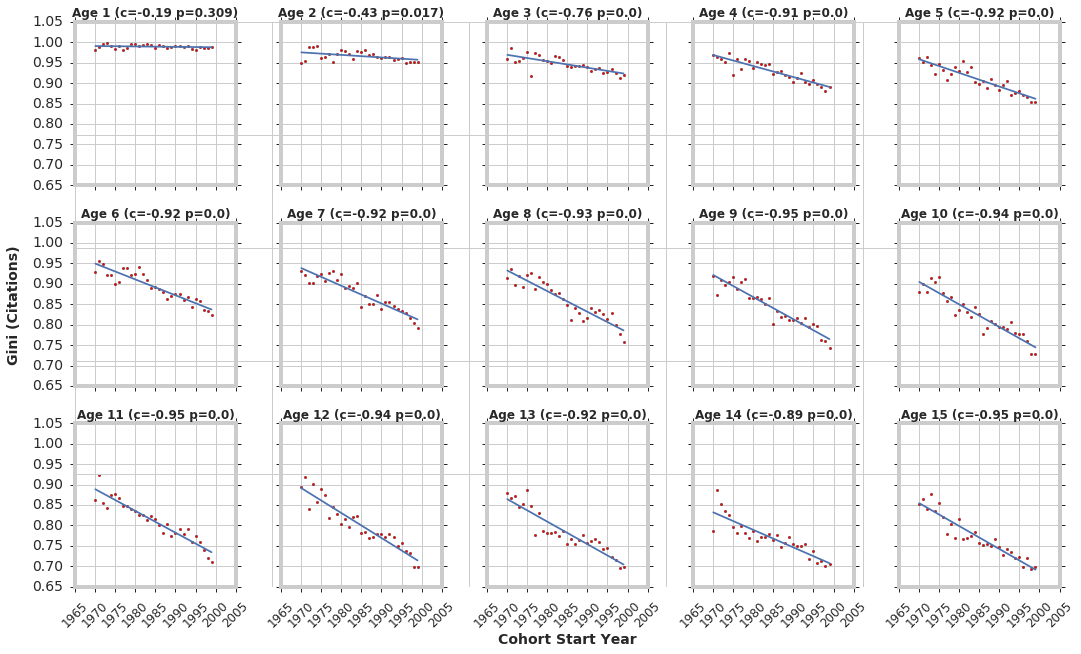

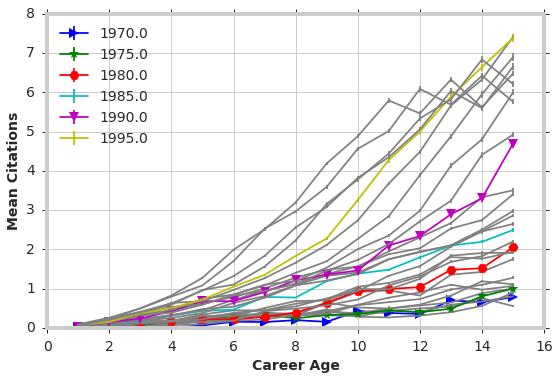

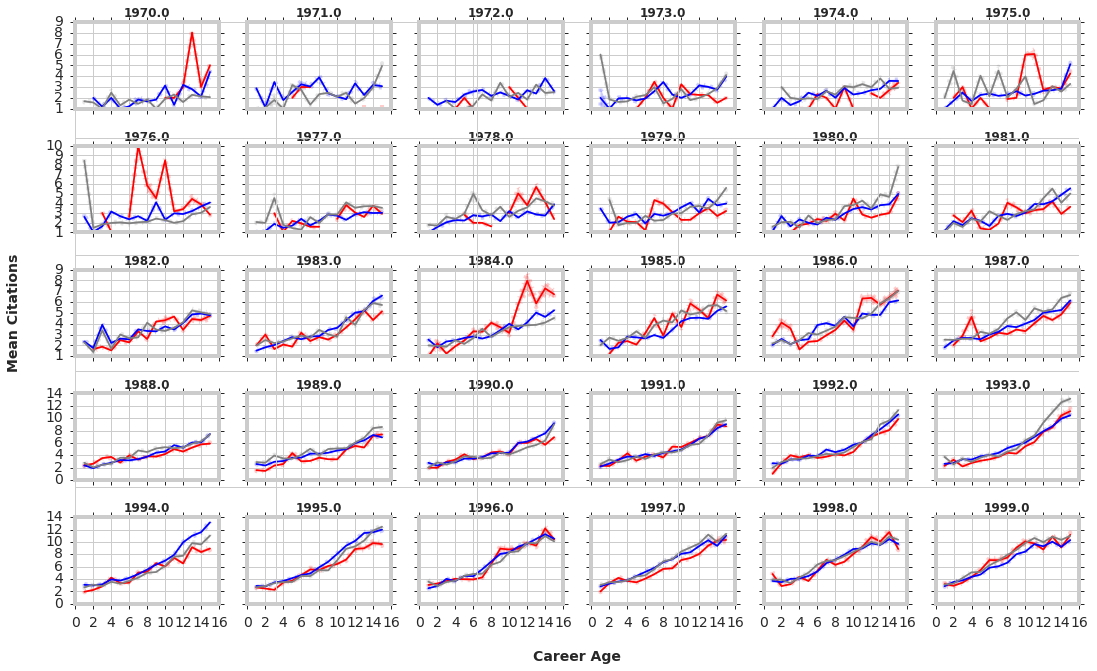

In [12]:


#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', cohort_start_years, CAREER_LENGTH, 'Citations Count')

plot.run_cohort_analysis(groupByYearData, cohort_start_years, CAREER_LENGTH, "num_cit", "Citations")  


### Cohort Analysis (Cum Num Cit)

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


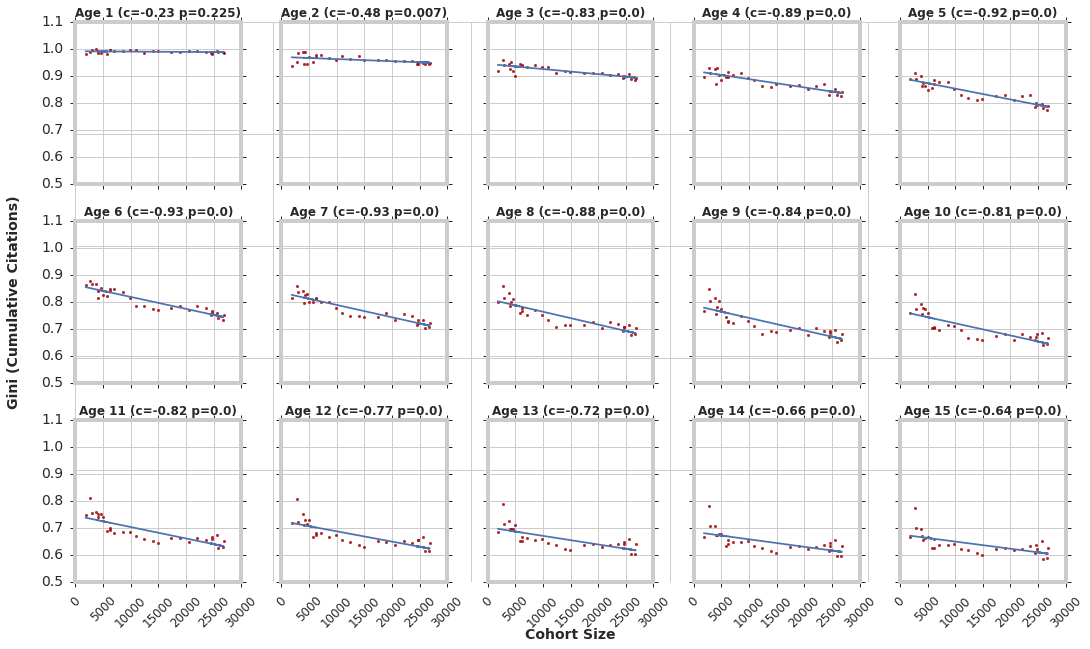

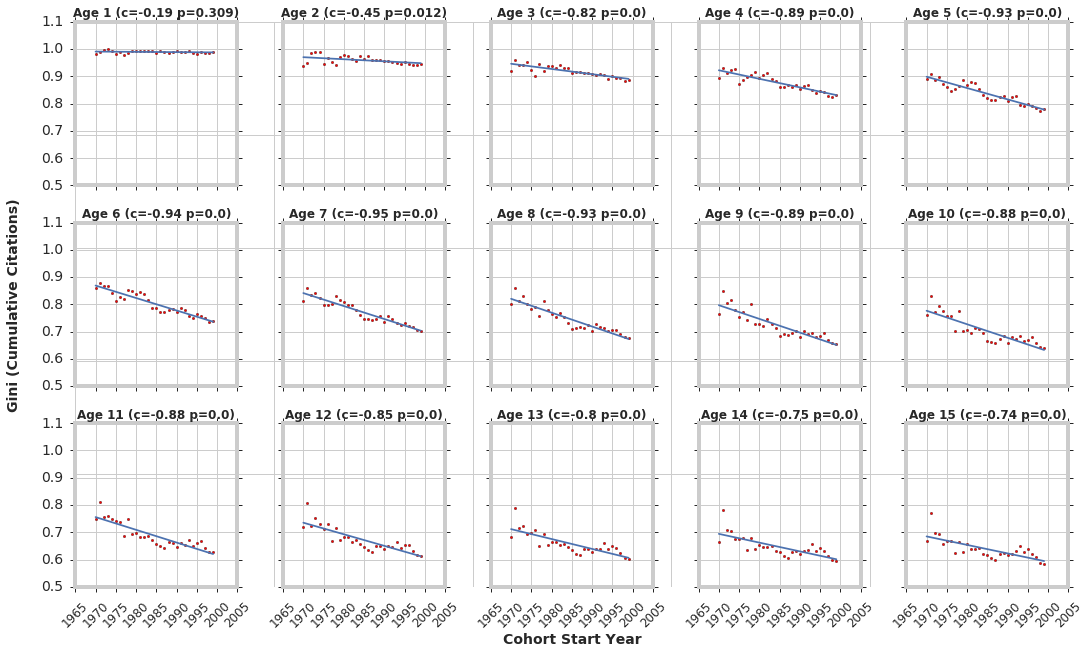

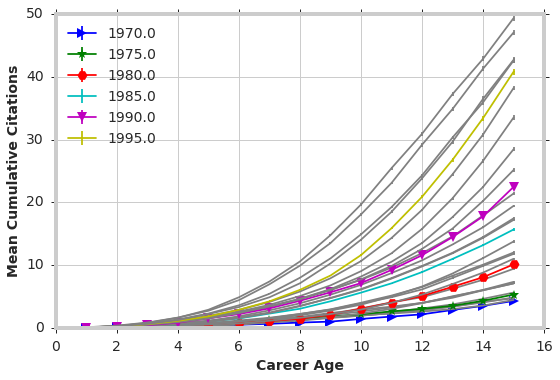

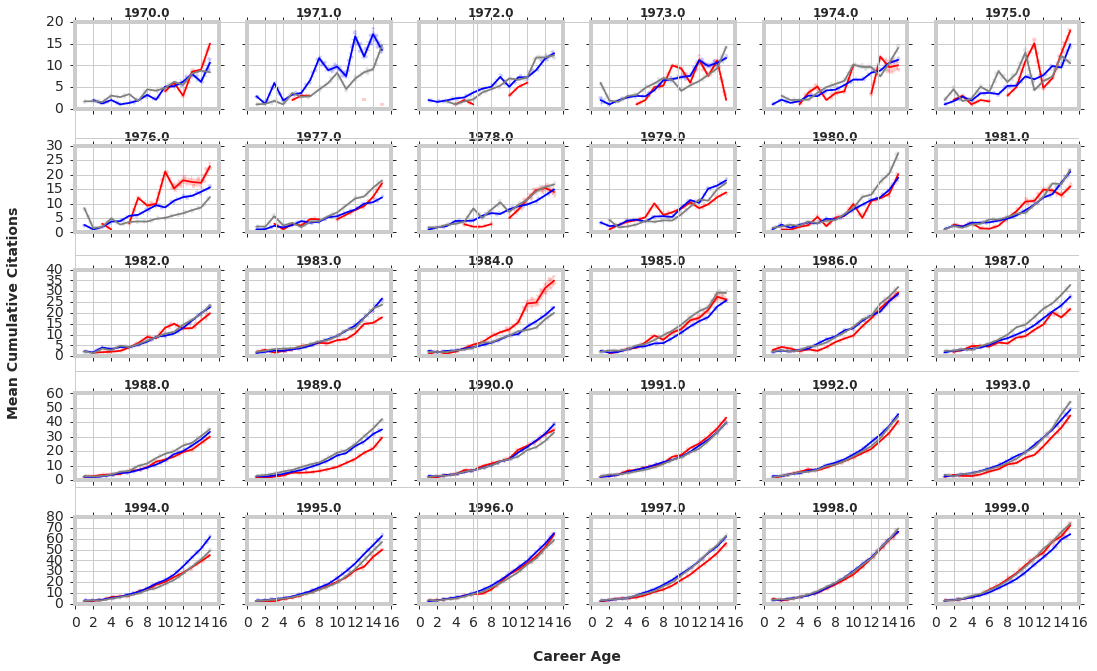

In [13]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, CAREER_LENGTH, "cum_num_cit", "Cumulative Citations")  


### Cumulative Distributions for Selected Cohorts and Career Ages

how do these distributions differ?

  year:1970.0    age: 1
Counter({0.0: 1801, 1.0: 31, 2.0: 11})
  year:1972.0    age: 1
Counter({0.0: 2980, 2.0: 10})
  year:1982.0    age: 1
Counter({0.0: 8548, 3.0: 36, 2.0: 20, 1.0: 15})
  year:1992.0    age: 1
Counter({0.0: 23204, 1.0: 104, 2.0: 96, 4.0: 74, 3.0: 63, 6.0: 3, 5.0: 1})
  year:1999.0    age: 1
Counter({0.0: 25468, 3.0: 164, 2.0: 109, 1.0: 55, 6.0: 33, 5.0: 27, 4.0: 25, 9.0: 7, 7.0: 2})


C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


  year:1970.0    age: 5
Counter({0.0: 1755, 1.0: 80, 4.0: 8})
  year:1972.0    age: 5
Counter({0.0: 2830, 1.0: 108, 4.0: 34, 2.0: 15, 3.0: 3})
  year:1982.0    age: 5
Counter({0.0: 7666, 1.0: 269, 2.0: 236, 3.0: 224, 4.0: 110, 5.0: 39, 7.0: 31, 9.0: 18, 6.0: 17, 10.0: 8, 8.0: 1})
  year:1992.0    age: 5
Counter({0.0: 19895, 2.0: 1062, 3.0: 822, 4.0: 460, 1.0: 451, 5.0: 224, 6.0: 193, 7.0: 121, 9.0: 83, 8.0: 82, 10.0: 74, 15.0: 41, 43.0: 23, 12.0: 14})
  year:1999.0    age: 5
Counter({0.0: 19255, 2.0: 1543, 3.0: 1448, 4.0: 901, 1.0: 553, 5.0: 524, 6.0: 431, 9.0: 269, 8.0: 242, 7.0: 134, 10.0: 106, 11.0: 81, 12.0: 73, 28.0: 65, 15.0: 37, 30.0: 33, 13.0: 31, 29.0: 23, 16.0: 21, 19.0: 16, 37.0: 16, 42.0: 15, 44.0: 15, 17.0: 14, 20.0: 13, 24.0: 11, 14.0: 10, 18.0: 10})
  year:1970.0    age: 10
Counter({0.0: 1511, 1.0: 135, 2.0: 78, 5.0: 52, 4.0: 36, 3.0: 31})
  year:1972.0    age: 10
Counter({0.0: 2494, 1.0: 189, 3.0: 174, 2.0: 92, 4.0: 24, 5.0: 17})
  year:1982.0    age: 10
Counter({0.0: 6

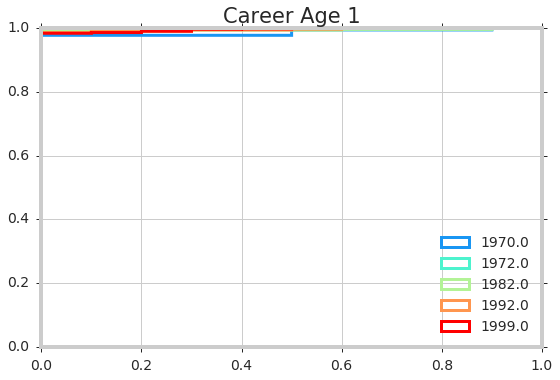

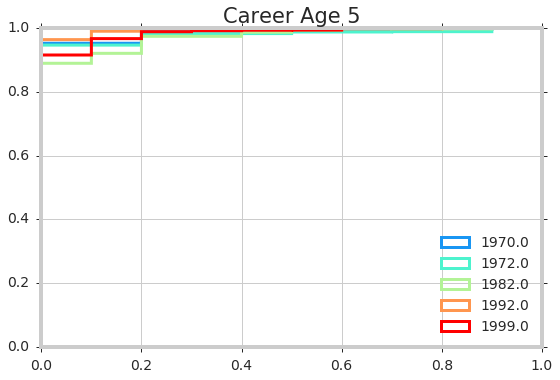

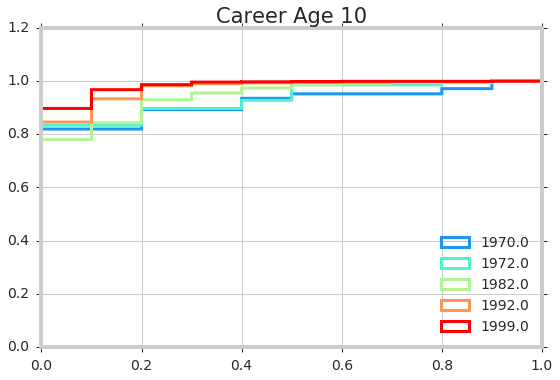

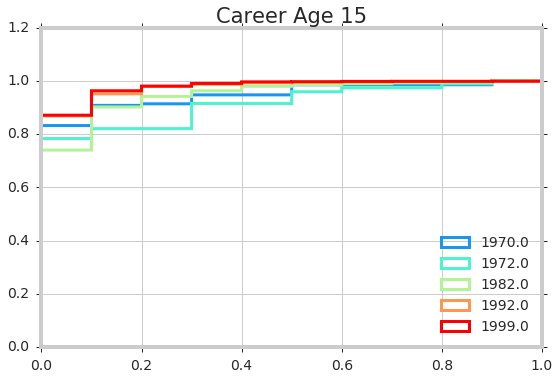

In [14]:
from importlib import reload
reload(plot)

cohort_start_years = [1970, 1972, 1982, 1992, 1999]

cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, CAREER_LENGTH, 'num_cit')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_cit', 'Number of Citations')



### Why is there a sudden increase in mean citation count for cohort started in 1985?

In [15]:
_1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1985] 
_1985Authors.shape

(12331, 8)

In [16]:
_1985Authors.columns

Index(['year', 'author', 'num_cit', 'start_year', 'end_year', 'total_num_pub',
       'career_length', 'gender'],
      dtype='object')

In [17]:
_1985Authors.sort(columns=['num_cit'], axis = 0, ascending=False,inplace=False)

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender
210541,2008,deborah estrin,246,1985.0,2017.0,220.0,32.0,f
136613,2005,deborah estrin,229,1985.0,2017.0,220.0,32.0,f
239412,2009,deborah estrin,197,1985.0,2017.0,220.0,32.0,f
183611,2007,deborah estrin,180,1985.0,2017.0,220.0,32.0,f
300870,2011,deborah estrin,175,1985.0,2017.0,220.0,32.0,f
159006,2006,deborah estrin,172,1985.0,2017.0,220.0,32.0,f
270153,2010,deborah estrin,170,1985.0,2017.0,220.0,32.0,f
195408,2007,moti yung,145,1985.0,2017.0,363.0,32.0,none
253093,2009,moti yung,127,1985.0,2017.0,363.0,32.0,none
116826,2004,deborah estrin,125,1985.0,2017.0,220.0,32.0,f


In [18]:
_1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
_1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
print(_1995_2000_year_1985Authors.shape)
_1995_2000_year_1985Authors.head(10)

(3483, 8)


,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender
2824,1985,barry d. van veen,3,1985.0,2017.0,72.0,32.0,m
2897,1985,david g. meyer,3,1985.0,2013.0,8.0,28.0,none
2945,1985,eiji kuno,1,1985.0,2008.0,3.0,23.0,m
2961,1985,feng qian,3,1985.0,2017.0,84.0,32.0,none
2990,1985,giovanni jacovitti,2,1985.0,2016.0,42.0,31.0,m
3011,1985,harald søndergaard,2,1985.0,2017.0,78.0,32.0,m
3047,1985,j. michael mccarthy,2,1985.0,2009.0,13.0,24.0,none
3077,1985,jesse l. barlow,4,1985.0,2017.0,29.0,32.0,m
3083,1985,johan håstad,3,1985.0,2016.0,113.0,31.0,m
3131,1985,layek abdel-malek,2,1985.0,2007.0,4.0,22.0,none


In [19]:
temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
temp.head()

#print(temp1['id2'].unique())

,year,author,num_cit
1961,1996,robert k. brayton,41
3126,2000,bart selman,34
3167,2000,david heckerman,33
2323,1997,s. arun-kumar,31
3010,1999,robert k. brayton,31


In [20]:
donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
donatella

,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender


C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


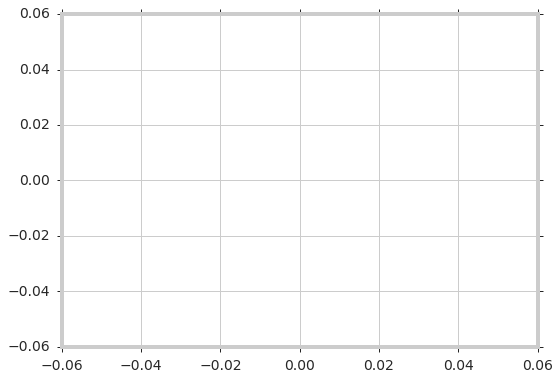

In [21]:
plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [22]:
authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender
37115,1997,donatella sciuto,2,1987.0,2016.0,349.0,29.0,f
44411,1998,donatella sciuto,9,1987.0,2016.0,349.0,29.0,f
61992,2000,donatella sciuto,4,1987.0,2016.0,349.0,29.0,f
73049,2001,donatella sciuto,15,1987.0,2016.0,349.0,29.0,f
85593,2002,donatella sciuto,25,1987.0,2016.0,349.0,29.0,f
100127,2003,donatella sciuto,13,1987.0,2016.0,349.0,29.0,f
117149,2004,donatella sciuto,3,1987.0,2016.0,349.0,29.0,f
136979,2005,donatella sciuto,15,1987.0,2016.0,349.0,29.0,f
159416,2006,donatella sciuto,38,1987.0,2016.0,349.0,29.0,f
184057,2007,donatella sciuto,8,1987.0,2016.0,349.0,29.0,f


## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

In [23]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

In [24]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

In [25]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

In [26]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)